<a href="https://colab.research.google.com/github/onlygoodman/dacon_shopping_reviewscore_predict/blob/main/project_shop_006.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

001 - https://wikidocs.net/94600 네이버 쇼핑 리뷰 데이터 분석을 참조하여 0,1 긍부정 이진 분류를 통해 확률을 0~5로 확장하여 예측


002 - 001 코드에서 target 그대로 활용, 다중분류로 예측 시도

003 - 002 코드에 dense layer 64, 32, 16, 8 사이에 각각 dropdout 0.2~0.5 적용하여 추가학습 epoch 25로 변경 early stop 인내값 8로 변경

004 - 003에서 epoch, batch-size 등 hyper parameter search에 유의미한 결과를 얻지 못하여 hyperband를 활용하여 하이퍼파라미터 튜닝 시도

005 - 004에서 얻은 하이퍼파라미터 튜닝 결과 대입하여 val_acc 측정 시도

006 - 005모델의 결과를 개선하기 위해 우선 for 문으로 hidden, dense layer, batch size 하이퍼파라미터 튜닝 시도 256 32 16 값 도출 후 결과 제출시도



In [1]:
# Colab에 Mecab 설치
!git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git
%cd Mecab-ko-for-Google-Colab
!bash install_mecab-ko_on_colab190912.sh

Cloning into 'Mecab-ko-for-Google-Colab'...
remote: Enumerating objects: 115, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 115 (delta 11), reused 10 (delta 3), pack-reused 91
Receiving objects: 100% (115/115), 1.27 MiB | 30.97 MiB/s, done.
Resolving deltas: 100% (50/50), done.
/content/Mecab-ko-for-Google-Colab
Installing konlpy.....
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 19.4 MB 1.2 MB/s 
     |████████████████████████████████| 453 kB 58.0 MB/s 
Done
Installing mecab-0.996-ko-0.9.2.tar.gz.....
from https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
--2022-07-15 06:53:51--  https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
Resolving bitbucket.org (bitbucket.org)... 104.192.141.1, 2406:da00:ff00::22e9:9f55, 2406:da00:ff00::3403:4be7, ...
Connecting to bitbucket.org (b

In [2]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from collections import Counter
from konlpy.tag import Mecab
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [3]:
# Train dataset은 Label이 존재하지 않음
train_data = pd.read_csv("/content/drive/MyDrive/shopping_dataset/train.csv")
test_data = pd.read_csv("/content/drive/MyDrive/shopping_dataset/test.csv")
submit = pd.read_csv("/content/drive/MyDrive/shopping_dataset/sample_submission.csv")

In [4]:
train_data.head(10)
train_data['target'].unique()

array([2, 1, 5, 4])

In [5]:
def predata(data):
  data['label'] = np.select([data.target > 3], [1], default = 0)

  #혹시 중복이 있다면 제거
  data.drop_duplicates(subset=['reviews'], inplace=True)

In [6]:
predata(train_data)

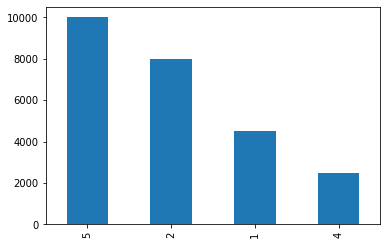

In [7]:
train_data['target'].value_counts().plot(kind='bar')

In [8]:
print(train_data.groupby('target').size().reset_index(name = 'count'))

   target  count
0       1   4499
1       2   8000
2       4   2500
3       5  10000


In [9]:
# 한글과 공백을 제외하고 모두 제거
train_data['reviews'] = train_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train_data['reviews'].replace('', np.nan, inplace=True)
print(train_data.isnull().sum())

id         0
reviews    0
target     0
label      0
dtype: int64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


In [10]:
# test_data.drop_duplicates(subset = ['reviews'], inplace=True) # 중복 제거
# test_data['reviews'] = test_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
# test_data['reviews'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
# test_data = test_data.dropna(how='any') # Null 값 제거
# print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

In [23]:
stopwords = ['도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', '인',
             '듯', '과', '와', '네', '들', '듯', '지', '임', '게', '어', '거', '기', '했', '습니다']
mecab = Mecab()

train_data['tokenized'] = train_data['reviews'].apply(mecab.morphs)
train_data['tokenized'] = train_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

# test_data['tokenized'] = test_data['reviews'].apply(mecab.morphs)
# test_data['tokenized'] = test_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

In [24]:
negative_words = np.hstack(train_data[train_data.label == 0]['tokenized'].values)
positive_words = np.hstack(train_data[train_data.label == 1]['tokenized'].values)

In [25]:
negative_word_count = Counter(negative_words)
print(negative_word_count.most_common(20))

[('네요', 5241), ('안', 3373), ('는데', 3360), ('어요', 2568), ('있', 2222), ('너무', 2157), ('좋', 1623), ('배송', 1621), ('구매', 1553), ('같', 1478), ('없', 1471), ('되', 1434), ('아요', 1433), ('잘', 1374), ('그냥', 1373), ('않', 1278), ('요', 1270), ('나', 1253), ('만', 1140), ('로', 1073)]


In [26]:
positive_word_count = Counter(positive_words)
print(positive_word_count.most_common(20))

[('좋', 6531), ('아요', 3515), ('네요', 3291), ('잘', 3190), ('어요', 3091), ('구매', 2670), ('있', 2145), ('배송', 1993), ('는데', 1957), ('먹', 1625), ('합니다', 1589), ('재', 1533), ('너무', 1434), ('같', 1365), ('만족', 1206), ('쓰', 1132), ('아', 1054), ('해서', 996), ('사용', 970), ('았', 929)]


In [27]:
print(len(negative_word_count))
print(len(positive_word_count))

13527
10460


평점 : 1점의 평균 길이 : 17.338519671038007
평점 : 2점의 평균 길이 : 16.151125
평점 : 3점의 평균 길이 : nan
평점 : 4점의 평균 길이 : 13.9672
평점 : 5점의 평균 길이 : 12.9144


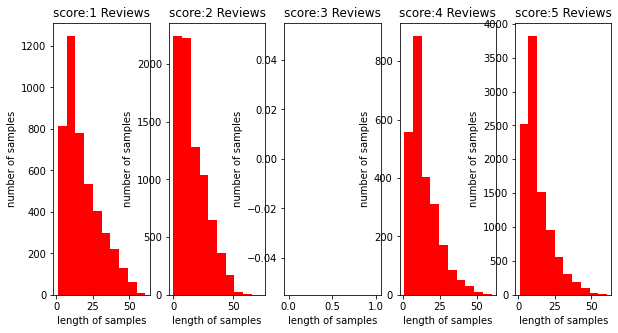

In [28]:
fig,(ax1,ax2,ax3,ax4,ax5) = plt.subplots(1,5,figsize=(10,5))

axlist=[0,ax1,ax2,ax3,ax4,ax5]

for i in range(1, 6):
  text_len = train_data[train_data['target']==i]['tokenized'].map(lambda x: len(x))
  axlist[i].hist(text_len, color='red')
  axlist[i].set_title('score:{} Reviews'.format(i))
  axlist[i].set_xlabel('length of samples')
  axlist[i].set_ylabel('number of samples')
  print('평점 : {}점의 평균 길이 :'.format(i), np.mean(text_len))
plt.show()

In [29]:
X_train = train_data['tokenized'].values
train_data1 = pd.get_dummies(train_data['target'])

In [30]:
y_train = train_data1.values
y_train

array([[0, 1, 0, 0],
       [1, 0, 0, 0],
       [0, 1, 0, 0],
       ...,
       [0, 0, 1, 0],
       [0, 1, 0, 0],
       [0, 0, 0, 1]], dtype=uint8)

In [31]:
y_train.shape

(24999, 4)

In [32]:
#정수인코딩
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [33]:
threshold = 2
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 17529
등장 빈도가 1번 이하인 희귀 단어의 수: 8171
단어 집합에서 희귀 단어의 비율: 46.61418221233385
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 2.2007827040188324


In [34]:
# 전체 단어 개수 중 빈도수 2이하인 단어 개수는 제거.
# 0번 패딩 토큰과 1번 OOV 토큰을 고려하여 +2
vocab_size = total_cnt - rare_cnt + 2
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 9360


In [35]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24999 entries, 0 to 24999
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         24999 non-null  int64 
 1   reviews    24999 non-null  object
 2   target     24999 non-null  int64 
 3   label      24999 non-null  int64 
 4   tokenized  24999 non-null  object
dtypes: int64(3), object(2)
memory usage: 1.1+ MB


In [36]:
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV') 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
# X_test = tokenizer.texts_to_sequences(X_test)

In [37]:
print(X_train[:3])

[[354, 18, 147, 115, 170, 312, 4], [40, 30, 7, 10, 771, 1, 2530, 298, 892, 10, 387, 5, 70, 386, 171, 2412, 31, 1402, 12, 586, 2], [148, 80, 143, 84, 1274, 39, 183, 5, 79, 71, 199, 54, 84, 1876, 8, 866, 1274, 4402, 8, 2, 86, 175, 42, 41, 19, 452, 11, 472, 266, 340, 180, 4]]


리뷰의 최대 길이 : 73
리뷰의 평균 길이 : 14.851674066962678


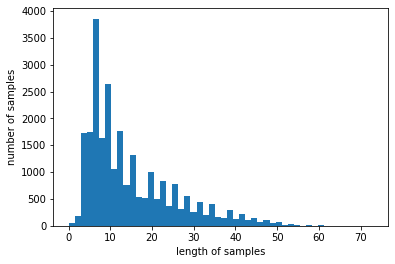

In [38]:
#패딩 작업

print('리뷰의 최대 길이 :',max(len(review) for review in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(review) for review in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [39]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

In [40]:
max_len = 60
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 60 이하인 샘플의 비율: 99.98399935997439


In [41]:
X_train = pad_sequences(X_train, maxlen=max_len)
# X_test = pad_sequences(X_test, maxlen=max_len)

In [49]:
print("{:.4f}".format(0.3333333333))
print('{:>4}'.format(3))

0.3333
   3


In [56]:
from tensorflow.keras.layers import Embedding, Dense, GRU, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

model_num = 1
max_acc = 0
best_model_num = 0
best_hu = 0
best_du = 0
best_batch = 0

for hu in [2**i for i in range(6, 10)]:
  embedding_dim = 100
  hidden_units = hu
  for du in [2**i for i in range(5, 9) if 2**i<hu]:
    # tf.keras.layers.Dense(units=24, activation="relu"), 
    # tf.keras.layers.Dense(units=12, activation="relu"), 
    model = Sequential()
    # model.add(GRU(units=50, activation="relu", return_sequences=True, input_shape = (X_train.shape[1], 5)))
    model.add(Embedding(vocab_size, embedding_dim))
    model.add(GRU(hidden_units))
    model.add(Dense(du, activation='relu'))
    model.add(Dense(4, activation='softmax'))

    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
    mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

    model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])
    # model.summary()

    for batch in [16, 32, 64]:
      hist = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=batch, validation_split=0.2)
      
      if max(list(hist.history['val_acc']))>max_acc:
        max_acc = max(list(hist.history['val_acc']))
        best_model_num = model_num
        best_hu, best_du, best_batch = hu, du, batch
      
      model_num+=1

print("best model is model_num : {} and the best val_acc score is {:.4f}".format(best_model_num, max_acc))
print("best hidden units, dense layer, batch is {}, {}, {}".format(best_hu, best_du, best_batch))

Epoch 1/15
1249/1250 [============================>.] - ETA: 0s - loss: 0.9262 - acc: 0.6148
Epoch 1: val_acc improved from -inf to 0.64720, saving model to best_model.h5
1250/1250 [==============================] - 12s 8ms/step - loss: 0.9261 - acc: 0.6148 - val_loss: 0.8365 - val_acc: 0.6472
Epoch 2/15
1244/1250 [============================>.] - ETA: 0s - loss: 0.8099 - acc: 0.6598
Epoch 2: val_acc improved from 0.64720 to 0.66080, saving model to best_model.h5
1250/1250 [==============================] - 9s 7ms/step - loss: 0.8100 - acc: 0.6596 - val_loss: 0.8118 - val_acc: 0.6608
Epoch 3/15
1245/1250 [============================>.] - ETA: 0s - loss: 0.7539 - acc: 0.6934
Epoch 3: val_acc improved from 0.66080 to 0.66400, saving model to best_model.h5
1250/1250 [==============================] - 10s 8ms/step - loss: 0.7539 - acc: 0.6932 - val_loss: 0.8124 - val_acc: 0.6640
Epoch 4/15
1248/1250 [============================>.] - ETA: 0s - loss: 0.7061 - acc: 0.7156
Epoch 4: val_acc 

In [62]:
embedding_dim = 100
hidden_units = best_hu
model = Sequential()

model.add(Embedding(vocab_size, embedding_dim))
model.add(GRU(hidden_units))
model.add(Dense(best_du, activation='relu'))
model.add(Dense(4, activation='softmax'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])
# model.summary()

hist = model.fit(X_train, y_train, epochs=5, callbacks=[es, mc], batch_size=best_batch, validation_split=0.2)

Epoch 1/5
1247/1250 [============================>.] - ETA: 0s - loss: 0.9295 - acc: 0.6140
Epoch 1: val_acc improved from -inf to 0.65240, saving model to best_model.h5
1250/1250 [==============================] - 13s 8ms/step - loss: 0.9292 - acc: 0.6137 - val_loss: 0.8336 - val_acc: 0.6524
Epoch 2/5
1245/1250 [============================>.] - ETA: 0s - loss: 0.8007 - acc: 0.6627
Epoch 2: val_acc improved from 0.65240 to 0.67620, saving model to best_model.h5
1250/1250 [==============================] - 10s 8ms/step - loss: 0.8007 - acc: 0.6625 - val_loss: 0.7921 - val_acc: 0.6762
Epoch 3/5
1250/1250 [==============================] - ETA: 0s - loss: 0.7422 - acc: 0.6931
Epoch 3: val_acc did not improve from 0.67620
1250/1250 [==============================] - 10s 8ms/step - loss: 0.7422 - acc: 0.6931 - val_loss: 0.7995 - val_acc: 0.6694
Epoch 4/5
1248/1250 [============================>.] - ETA: 0s - loss: 0.6978 - acc: 0.7195
Epoch 4: val_acc did not improve from 0.67620
1250/1250

In [63]:
loaded_model = load_model('best_model.h5')

In [64]:
test_data.head()

,id,reviews
0,0,채소가 약간 시들어 있어요
1,1,발톱 두껍고 단단한 분들 써도 소용없어요 이 테이프 물렁거리고 힘이없어서 들어 올리...
2,2,부들부들 좋네요 입어보고 시원하면 또 살게요
3,3,이런 1. 8 골드 주라니깐 파란개 오네 회사전화걸어도 받지도 않고 머하자는거임?
4,4,검수도 없이 보내구 불량 배송비 5000원 청구하네요 완전별로 별하나도 아까워요


In [65]:
def score_predict(new_sentence):
  new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
  new_sentence = mecab.morphs(new_sentence)
  new_sentence = [word for word in new_sentence if not word in stopwords]
  encoded = tokenizer.texts_to_sequences([new_sentence])
  pad_new = pad_sequences(encoded, maxlen = max_len)

  scorebox=loaded_model.predict((pad_new))
  maxscore=max(list(scorebox[0]))
  scorelist=[1,2,4,5]
  # score = float(loaded_model.predict(pad_new))
  # star_score = int(score*100)//20+1
  for i in range(4):
    if scorebox[0][i]==maxscore:
      return scorelist[i]

In [66]:
print(score_predict("아 정말 좋아요!!"))

5


In [67]:
sentest= ["아진짜 좋아", "이거 대박", "정말 좋긴한데.. 뭔가 아쉬워요", "이거 진짜 진짜 너무 너무 별로다 ... 조상님이 울고가겠어요"]

for sen1 in sentest:
  print(sen1)
  print("다음 문장의 예측 별점은 {}점 입니다.".format(score_predict(sen1)))
  print()

아진짜 좋아
다음 문장의 예측 별점은 5점 입니다.

이거 대박
다음 문장의 예측 별점은 5점 입니다.

정말 좋긴한데.. 뭔가 아쉬워요
다음 문장의 예측 별점은 2점 입니다.

이거 진짜 진짜 너무 너무 별로다 ... 조상님이 울고가겠어요
다음 문장의 예측 별점은 1점 입니다.



In [68]:
train_data.head()

,id,reviews,target,label,tokenized
0,0,조아요 처음구입 싸게햇어요,2,0,"[조아, 요, 처음, 구입, 싸, 햇, 어요]"
1,1,생각보다 잘 안돼요 매지 바른지 하루밖에 안됐는데ㅠㅠ 천원가량 주고 사기 너무 아깝네요,1,0,"[생각, 보다, 잘, 안, 돼요, 매지, 바른, 하루, 밖에, 안, 됐, 는데, ㅠ..."
2,2,디자인은괜찮은데 상품이 금이가서 교환했는데 두번째받은상품도 까져있고 안쪽에 금이가져...,2,0,"[디자인, 괜찮, 은데, 상품, 금, 서, 교환, 는데, 두, 번, 째, 받, 상품..."
3,3,기전에 이 제품말고 이마트 트레이더스에서만 팔던 프리미엄 제품을 사용했었습니다 샘플...,2,0,"[기전, 제품, 말, 이마트, 트, 레이더스, 에서, 만, 팔, 던, 프리미엄, 제..."
4,4,튼튼하고 손목을 잘 받쳐주네요,5,1,"[튼튼, 손목, 잘, 받쳐, 주, 네요]"


In [69]:
score_predict("생각보다 잘 안돼요 매지 바른지 하루밖에 안됐는데ㅠㅠ 천원가량 주고 사기 너무 아깝네요")

1

In [ ]:
test_sen = test_data.reviews

pred = []

for sentence in test_sen:
  pred.append(score_predict(sentence))

In [ ]:
projectname = "shop"
model = "GRU"
testnum = "006"

submit["target"] = pred
submit.head() 
submit.to_csv("sub_{}_{}_model_{}.csv".format(testnum, projectname, model),index=False)

In [ ]:
submit.head()

In [ ]:
submit.head()

,id,target
0,0,2
1,1,2
2,2,5
3,3,2
4,4,2


In [ ]:
submit.head()

,id,target
0,0,5
1,1,2
2,2,5
3,3,2
4,4,2
